In [35]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from utils.acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader

import seaborn as sns


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import umap


# my defined model
from utils.vqVAE import VQVAE

from matplotlib.colors import ListedColormap


In [40]:
def codebook_hist_testset(model, val_loader):
    model.eval()
    hist = torch.zeros(model.vq_layer.K).to(device)
    with torch.no_grad():
        for batch in val_loader:
            hist += model.codebook_usage(batch.float().to(device))
    
    hist = hist.detach().cpu().numpy()
    unused_codes = len(np.where(hist == 0.0)[0])

    percentage = (model.vq_layer.K - unused_codes)*100/model.vq_layer.K

    print(f" ONLY {model.vq_layer.K - unused_codes} OF CODES WERE USED FROM {model.vq_layer.K}, WHICH MAKE {percentage} % OF CODES FROM THE CODE-BOOK")
    return hist



def codebook_distances(codeBook):
    # Compute the squared norms of each vector
    squared_norms = np.sum(codeBook**2, axis=1)
    
    # Use broadcasting to compute the pairwise squared differences
    dist_matrix = np.sqrt(squared_norms[:, np.newaxis] + squared_norms - 2 * np.dot(codeBook, codeBook.T))
    
    return dist_matrix


def codebook_cosinesim(codeBook):
    # Normalize each vector by its L2 norm
    norms = np.linalg.norm(codeBook, axis=1, keepdims=True)
    codeBook_normalized = codeBook / norms
    
    # Compute the cosine similarity matrix as the dot product of normalized vectors
    cosine_sim_matrix = np.dot(codeBook_normalized, codeBook_normalized.T)
    
    return cosine_sim_matrix


def plot_similarity_measure(sim_matrix):

    vmin = np.min(sim_matrix)
    vmax = np.max(sim_matrix)
    
    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, cmap='viridis', cbar_kws={'label': 'L2 Norm Distance'}, vmin=vmin, vmax=vmax, annot=False)
    
    # Set labels and title
    plt.title('Pairwise L2 Norm Distance Heatmap')
    plt.xlabel('Vector Index')
    plt.ylabel('Vector Index')

    # Show the plot
    plt.show()



In [8]:

L = 128 # image size L=W
BATCH_SIZE = 16



In [5]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")

test_dataset  = load_dataset(test_set_path)


In [9]:
input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

In [10]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 


In [11]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [12]:
vis_batch = next(iter(TestLoader)).to(device)

## Model 100

In [51]:
model_path = 'saved_models/vqvae_100_bestmodel.pth'

model = VQVAE(in_channels, 64, 512)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_3705004/1315759818.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


In [52]:
hist = codebook_hist_testset(model, TestLoader)
# hist = hist/torch.sum(hist)

 ONLY 89 OF CODES WERE USED FROM 512, WHICH MAKE 17.3828125 % OF CODES FROM THE CODE-BOOK


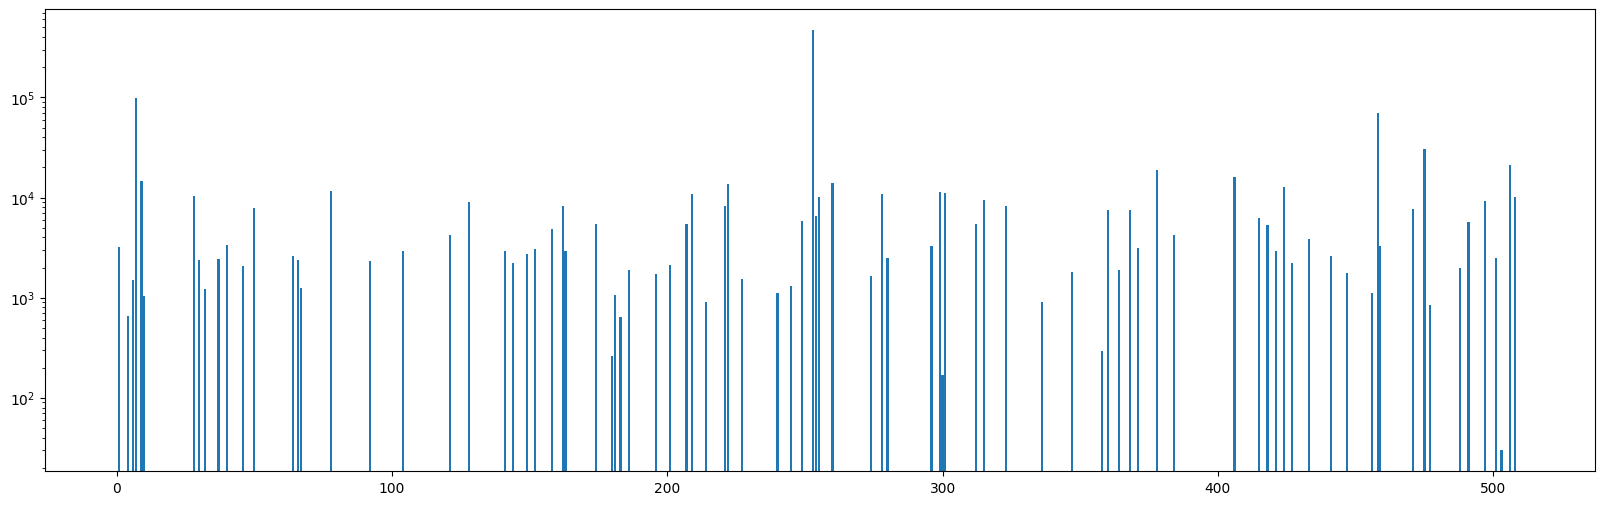

In [53]:
plt.figure(figsize=(20, 6))
plt.bar(range(len(hist)), hist)
plt.yscale('log')

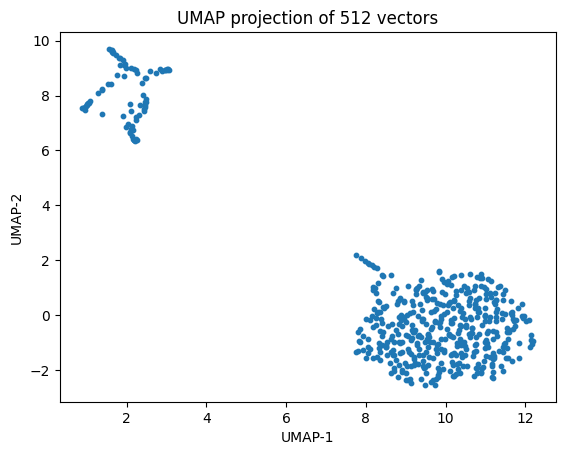

In [15]:
# codebook = model.vq_layer.embedding.weight.detach().cpu().numpy()

# reducer = umap.UMAP(n_components=2, random_state=42)

# # Fit and transform
# embedding = reducer.fit_transform(codebook)

# # Plot the result
# plt.scatter(embedding[:, 0], embedding[:, 1], s=10, cmap='Spectral')
# plt.title('UMAP projection of 512 vectors')
# plt.xlabel('UMAP-1')
# plt.ylabel('UMAP-2')
# plt.show()

In [54]:
codebook = model.vq_layer.embedding.weight.data.cpu().detach().numpy()

/tmp/ipykernel_3705004/1948428806.py:23: RuntimeWarning: invalid value encountered in sqrt
  dist_matrix = np.sqrt(squared_norms[:, np.newaxis] + squared_norms - 2 * np.dot(codeBook, codeBook.T))


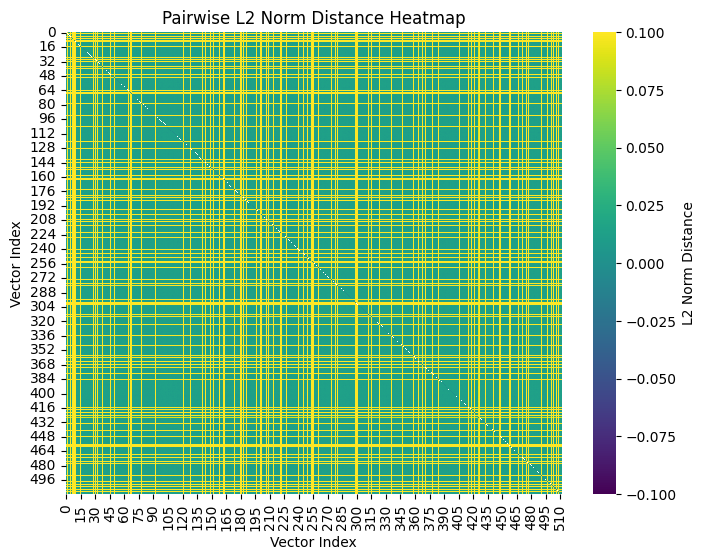

In [57]:
l2_sim = codebook_distances(codeBook= codebook)
plot_similarity_measure(l2_sim)

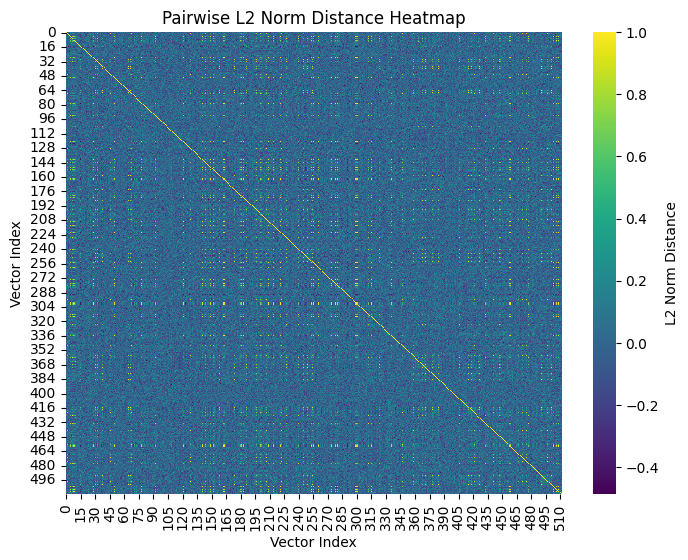

In [56]:
cos_sim = codebook_cosinesim(codeBook= codebook)
plot_similarity_measure(cos_sim)

## Model 101

In [16]:
model_path = 'saved_models/vqvae_101_bestmodel.pth'

model = VQVAE(in_channels, 64, 512)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

In [17]:
hist = codebook_hist_testset(model, TestLoader).detach().cpu().numpy()
# hist = hist/torch.sum(hist)

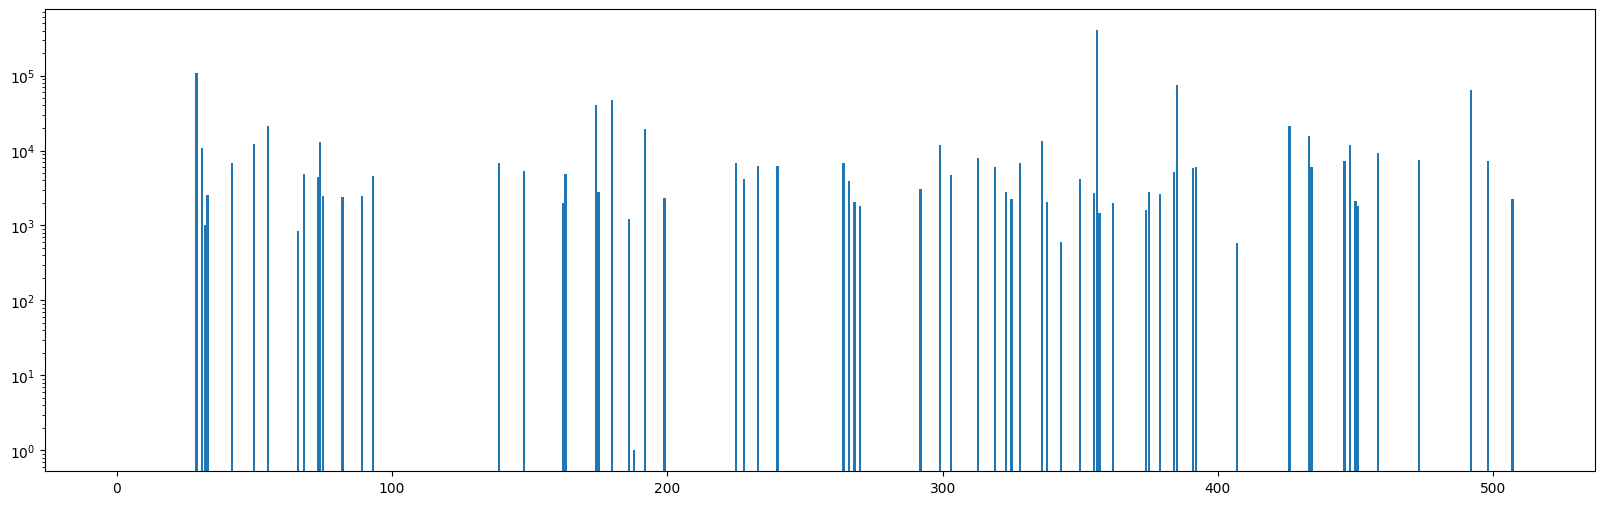

In [18]:
plt.figure(figsize=(20, 6))
plt.bar(range(len(hist)), hist)
plt.yscale('log')

In [19]:
#CodeBook percentage usage 
unused_codes = len(np.where(hist == 0.0)[0])

percentage = (512 - unused_codes)*100/512

print(f" ONLY {512 - unused_codes} OF CODES WERE USED, WHICH MAKE {percentage} % OF CODES FROM THE CODE-BOOK")


 ONLY 70 OF CODES WERE USED, WHICH MAKE 13.671875 % OF CODES FROM THE CODE-BOOK


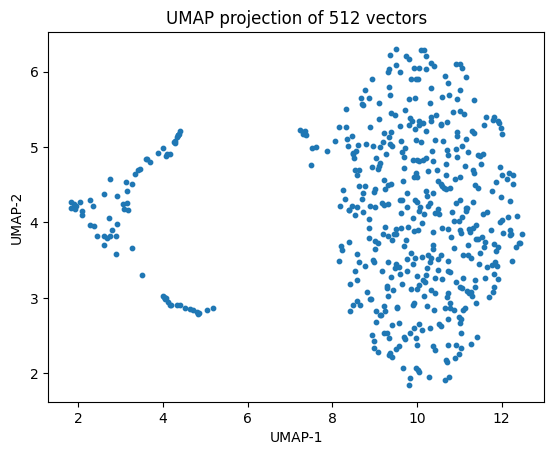

In [20]:
codebook = model.vq_layer.embedding.weight.detach().cpu().numpy()

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform
embedding = reducer.fit_transform(codebook)

# Plot the result
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, cmap='Spectral')
plt.title('UMAP projection of 512 vectors')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

# Model 102

In [46]:
model_path = 'saved_models/vqvae_102_bestmodel.pth'

model = VQVAE(in_channels, 32, 256)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

In [47]:
hist = codebook_hist_testset(model, TestLoader).detach().cpu().numpy()
# hist = hist/torch.sum(hist)

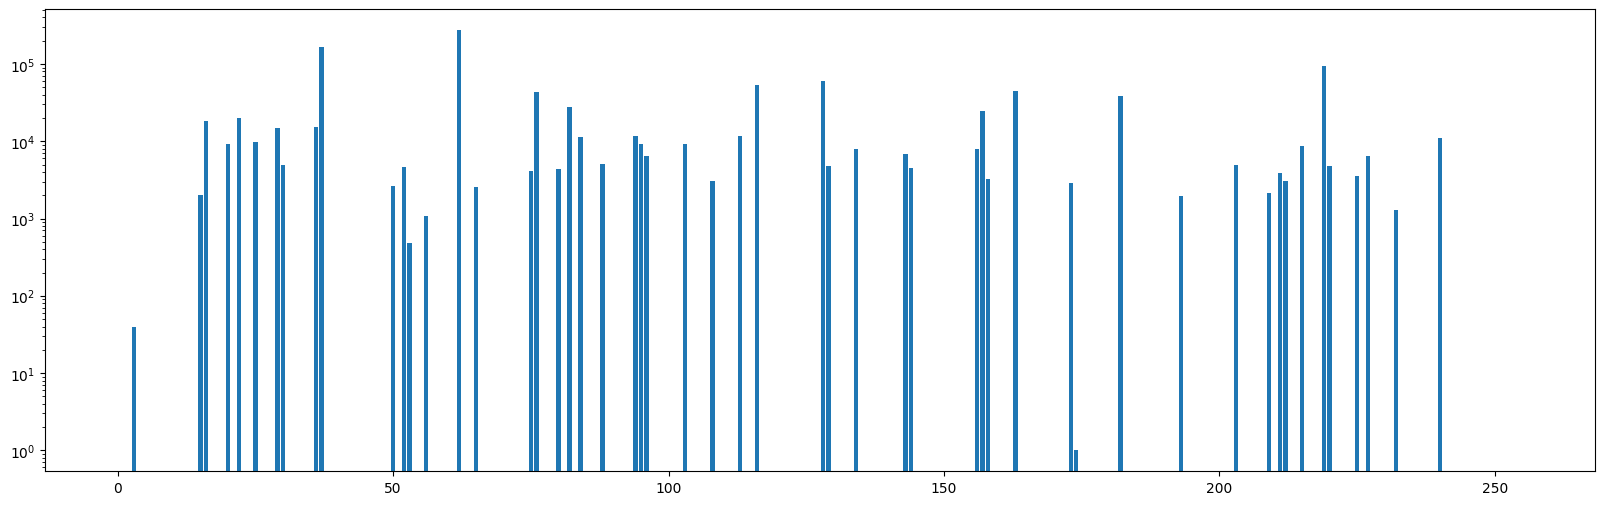

In [48]:
plt.figure(figsize=(20, 6))
plt.bar(range(len(hist)), hist)
plt.yscale('log')

In [51]:
#CodeBook percentage usage 
unused_codes = len(np.where(hist == 0.0)[0])

percentage = (model.vq_layer.K - unused_codes)*100/model.vq_layer.K

print(f" ONLY {model.vq_layer.K - unused_codes} OF CODES WERE USED, WHICH MAKE {percentage} % OF CODES FROM THE CODE-BOOK")


 ONLY 53 OF CODES WERE USED, WHICH MAKE 20.703125 % OF CODES FROM THE CODE-BOOK


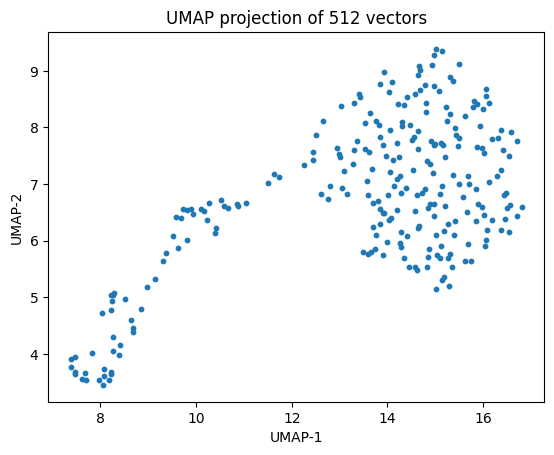

In [34]:
codebook = model.vq_layer.embedding.weight.detach().cpu().numpy()

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform
embedding = reducer.fit_transform(codebook)

# Plot the result
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, cmap='Spectral')
plt.title('UMAP projection of 512 vectors')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

# Model 103

In [52]:
model_path = 'saved_models/vqvae_103_bestmodel.pth'

model = VQVAE(in_channels, 64, 512)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

In [53]:
hist = codebook_hist_testset(model, TestLoader).detach().cpu().numpy()
# hist = hist/torch.sum(hist)

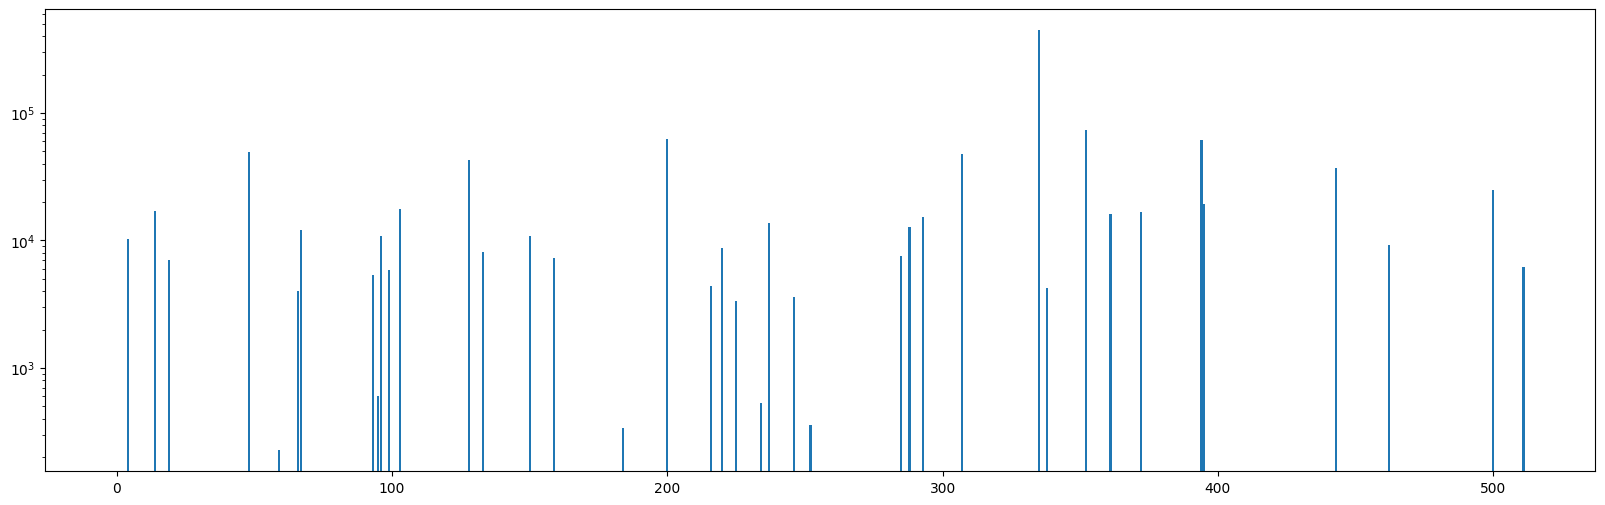

In [54]:
plt.figure(figsize=(20, 6))
plt.bar(range(len(hist)), hist)
plt.yscale('log')

In [55]:
#CodeBook percentage usage 
unused_codes = len(np.where(hist == 0.0)[0])
<
percentage = (512 - unused_codes)*100/512

print(f" ONLY {512 - unused_codes} OF CODES WERE USED, WHICH MAKE {percentage} % OF CODES FROM THE CODE-BOOK")


 ONLY 40 OF CODES WERE USED, WHICH MAKE 7.8125 % OF CODES FROM THE CODE-BOOK


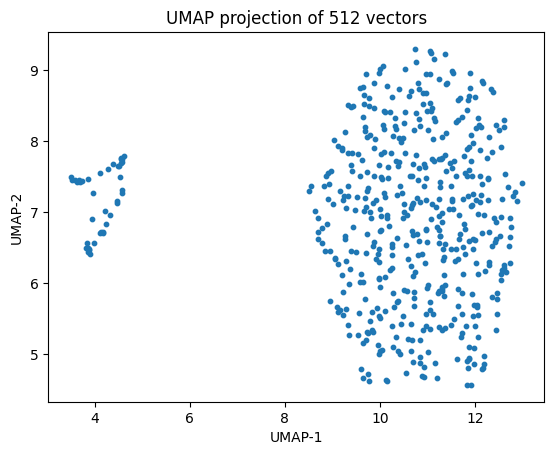

In [56]:
codebook = model.vq_layer.embedding.weight.detach().cpu().numpy()

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform
embedding = reducer.fit_transform(codebook)

# Plot the result
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, cmap='Spectral')
plt.title('UMAP projection of 512 vectors')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

--------------------------

# Re-Fit model

### model 100

In [16]:
model_path = 'Re_Fit_models/vqvae_100_bestmodel.pth'

model = VQVAE(in_channels, 64, 128)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_3705004/3391975194.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


In [18]:
hist = codebook_hist_testset(model, TestLoader)
# hist = hist/torch.sum(hist)

 ONLY 13 OF CODES WERE USED, WHICH MAKE 10.15625 % OF CODES FROM THE CODE-BOOK


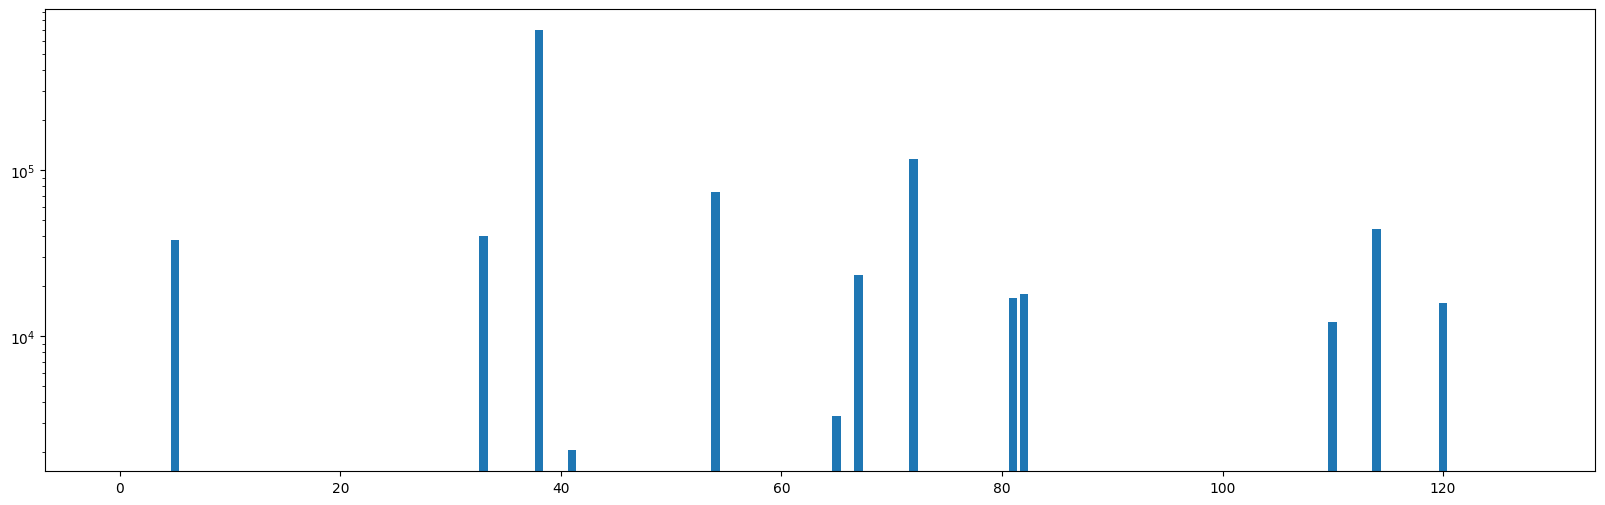

In [19]:
plt.figure(figsize=(20, 6))
plt.bar(range(len(hist)), hist)
plt.yscale('log')

/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/tmp/ipykernel_3705004/2193139998.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], s=10, cmap='Spectral')


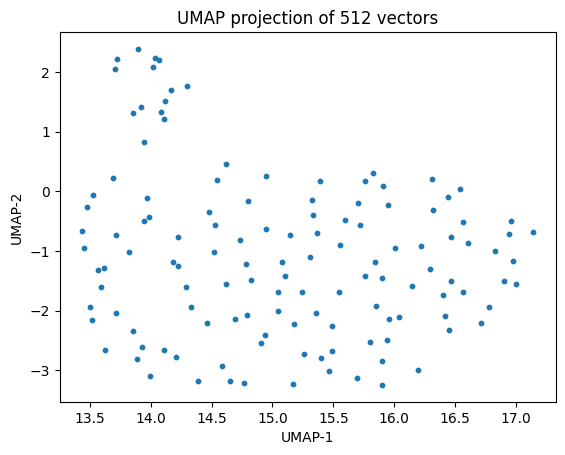

In [20]:
import umap

codebook = model.vq_layer.embedding.weight.detach().cpu().numpy()

reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform
embedding = reducer.fit_transform(codebook)

# Plot the result
plt.scatter(embedding[:, 0], embedding[:, 1], s=10, cmap='Spectral')
plt.title('UMAP projection of 512 vectors')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

In [24]:
codebook = model.vq_layer.embedding.weight.data.cpu().detach().numpy()

/tmp/ipykernel_3705004/1948428806.py:23: RuntimeWarning: invalid value encountered in sqrt
  dist_matrix = np.sqrt(squared_norms[:, np.newaxis] + squared_norms - 2 * np.dot(codeBook, codeBook.T))


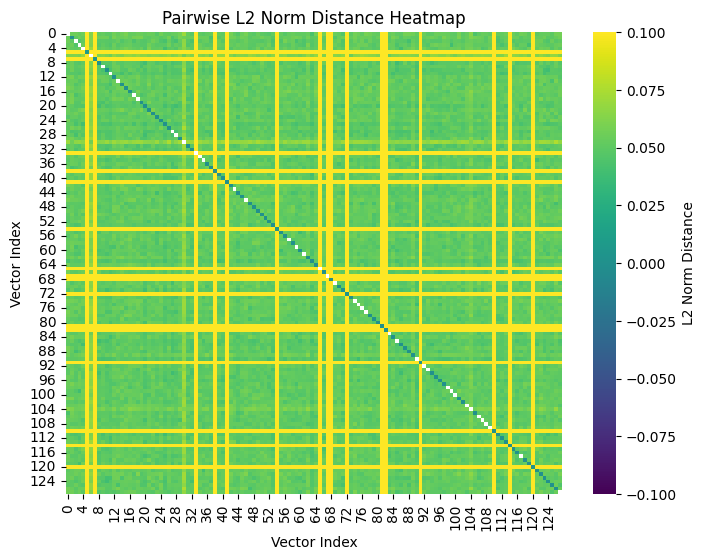

In [43]:
l2_sim = codebook_distances(codeBook= codebook)
plot_similarity_measure(l2_sim)c

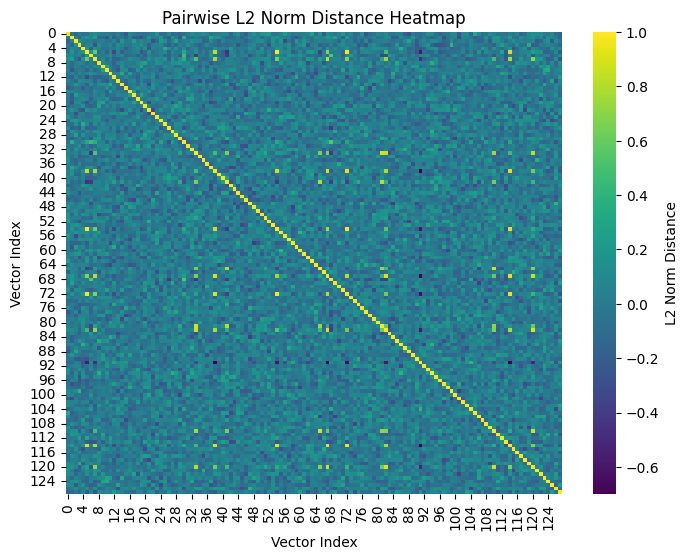

In [ ]:
cos_sim = codebook_cosinesim(codeBook= codebook)
plot_similarity_measure(cos_sim)

### model 101

In [44]:
model_path = 'Re_Fit_models/vqvae_101_bestmodel.pth'

model = VQVAE(in_channels, 64, 256)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.to(device)

/tmp/ipykernel_3705004/2892555141.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)['model_state_dict'])


In [45]:
hist = codebook_hist_testset(model, TestLoader)
# hist = hist/torch.sum(hist)

 ONLY 42 OF CODES WERE USED FROM 256, WHICH MAKE 16.40625 % OF CODES FROM THE CODE-BOOK


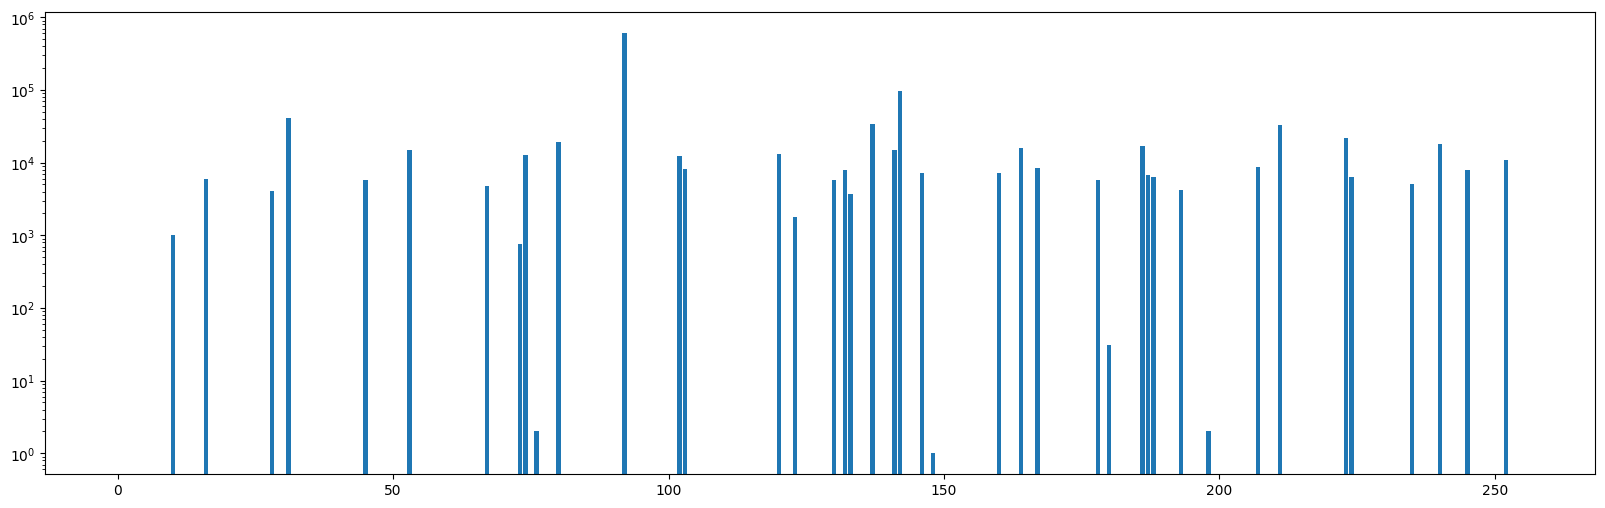

In [46]:
plt.figure(figsize=(20, 6))
plt.bar(range(len(hist)), hist)
plt.yscale('log')

In [47]:
# import umap

# codebook = model.vq_layer.embedding.weight.detach().cpu().numpy()

# reducer = umap.UMAP(n_components=2, random_state=42)

# # Fit and transform
# embedding = reducer.fit_transform(codebook)

# # Plot the result
# plt.scatter(embedding[:, 0], embedding[:, 1], s=10, cmap='Spectral')
# plt.title('UMAP projection of 512 vectors')
# plt.xlabel('UMAP-1')
# plt.ylabel('UMAP-2')
# plt.show()

In [48]:
codebook = model.vq_layer.embedding.weight.data.cpu().detach().numpy()

/tmp/ipykernel_3705004/1948428806.py:23: RuntimeWarning: invalid value encountered in sqrt
  dist_matrix = np.sqrt(squared_norms[:, np.newaxis] + squared_norms - 2 * np.dot(codeBook, codeBook.T))


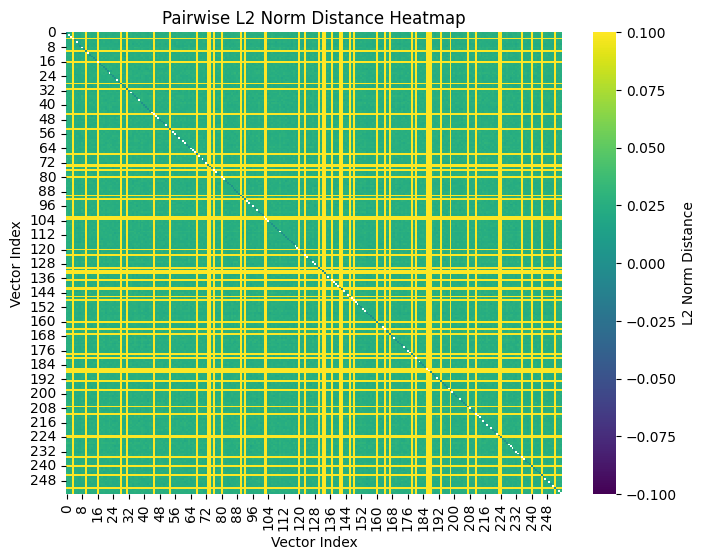

In [49]:
l2_sim = codebook_distances(codeBook= codebook)
plot_similarity_measure(l2_sim)

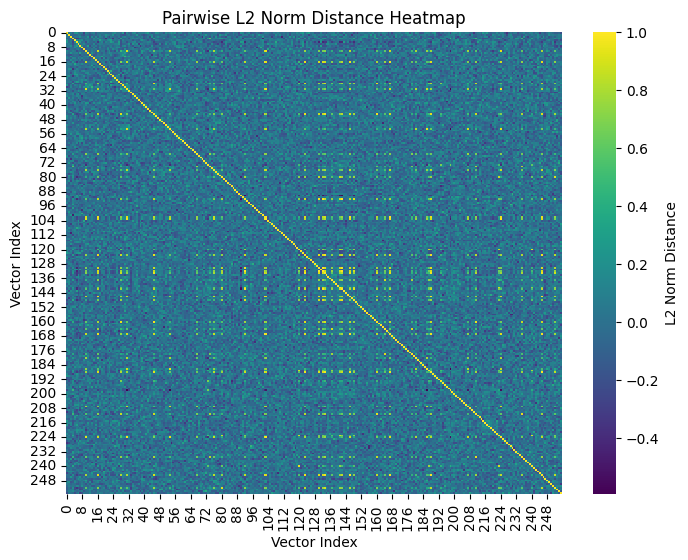

In [50]:
cos_sim = codebook_cosinesim(codeBook= codebook)
plot_similarity_measure(cos_sim)